In [1]:
# 8/18/23 - Parcel analysis

import matplotlib.pyplot as plt
import matplotlib as mpl
from netCDF4 import Dataset
from pylab import rcParams
import numpy as np
from matplotlib.patches import Rectangle
from matplotlib import cm
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import math as m
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

In [2]:
# Start by reading in parcel files

folder = "/glade/scratch/amuehr/H5_dry_parcel_output/" # This is the directory where CM1 v21.0 currently outputs files
filename = "cm1out_pdata.nc"
file = folder + filename
pdata = Dataset(file) # Prepare netCDF data to be read in from pdata file

# Read in 3D data
file = folder + "cm1out_000090.nc"
data = Dataset(file) # Prepare netCDF data to be read in from 3D data file


print(pdata.variables.keys()) # Display  parcel variable names
print(np.shape(pdata['w']))

dict_keys(['xh', 'yh', 'zh', 'time', 'x', 'y', 'z', 'u', 'v', 'w', 'mtime', 'th', 't', 'prs', 'pt1', 'pt2', 'pt3', 'pt4', 'qv', 'qc', 'qr', 'qi', 'qs', 'qg', 'nci', 'ncs', 'ncr', 'ncg', 'tke', 'dbz', 'b', 'vpg', 'zvort', 'rho', 'qsl', 'qsi'])
(151, 4760)


prcl_y [[11000.    ]
 [11000.1   ]
 [10999.619 ]
 [10998.556 ]
 [10996.905 ]
 [10994.667 ]
 [10991.84  ]
 [10988.421 ]
 [10984.407 ]
 [10979.781 ]
 [10974.527 ]
 [10968.6455]
 [10962.125 ]
 [10954.97  ]
 [10947.179 ]
 [10938.763 ]
 [10929.717 ]
 [10920.036 ]
 [10909.727 ]
 [10898.79  ]
 [10887.244 ]
 [10875.1045]
 [10862.395 ]
 [10849.138 ]
 [10835.378 ]
 [10821.14  ]
 [10806.468 ]
 [10791.417 ]
 [10776.038 ]
 [10760.415 ]
 [10744.632 ]
 [10728.774 ]
 [10712.958 ]
 [10697.274 ]
 [10681.839 ]
 [10666.76  ]
 [10652.138 ]
 [10638.091 ]
 [10624.747 ]
 [10612.198 ]
 [10600.55  ]
 [10589.923 ]
 [10580.405 ]
 [10572.093 ]
 [10565.082 ]
 [10559.48  ]
 [10555.364 ]
 [10552.833 ]
 [10551.982 ]
 [10552.885 ]
 [10555.601 ]
 [10560.175 ]
 [10566.673 ]
 [10575.156 ]
 [10585.66  ]
 [10598.222 ]
 [10612.897 ]
 [10629.722 ]
 [10648.729 ]
 [10669.909 ]
 [10693.297 ]
 [10718.906 ]
 [10746.743 ]
 [10776.833 ]
 [10809.219 ]
 [10843.871 ]
 [10880.779 ]
 [10919.923 ]
 [10961.293 ]
 [11004.826 ]
 [11050.528 ]

(250.0, 400.0)

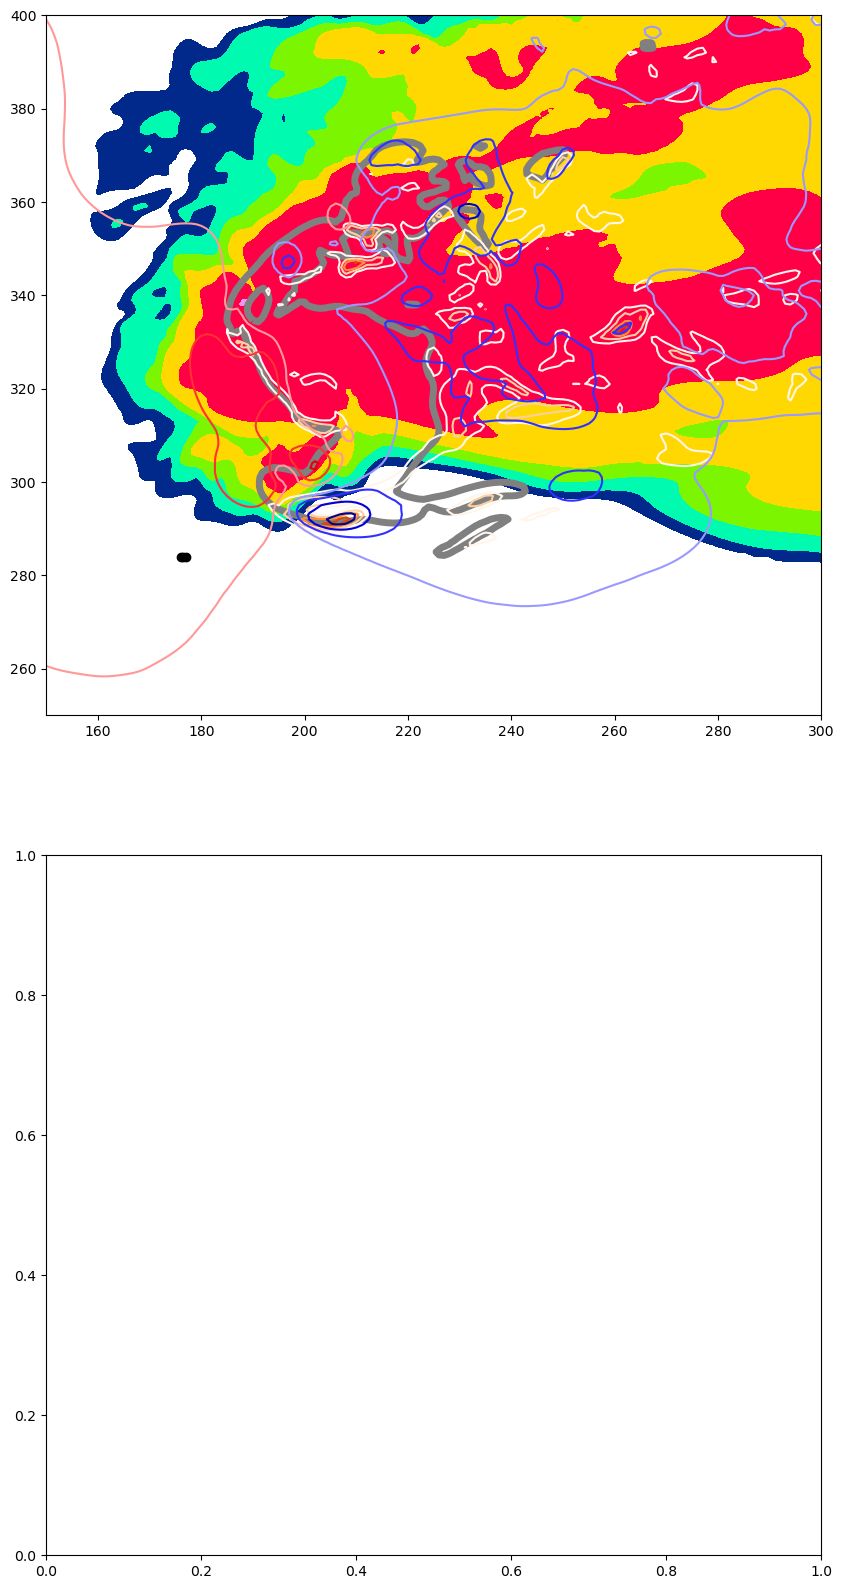

In [3]:
# Plot data
# REMEMBER: xh = parcel number
#           yh = time

# Initialize variables with x- and y-location of domain center
x_center = 240 ## REMEMBER TO CHANGE THESE FOR NEW RUN!!!! ###
y_center = 240 ## REMEMBER TO CHANGE THESE FOR NEW RUN!!!! ###

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,20)) # Set figure size and subplots
ax1.set_facecolor("white") # Background color
ax2.set_facecolor("white") # Background color

prcl_time = pdata["yh"][4584:4585]

prcl_x = pdata["x"][:,4584:4585]
prcl_y = pdata["y"][:,4584:4585]
prcl_z = pdata["z"][:,4584:4585]

#plt.contourf(prcl_x)
#plt.contourf(prcl_y)
#plt.contourf(prcl_z)
#plt.colorbar()

print("prcl_y", prcl_y)

ax1.contourf(data['dbz'][0,0,:,:], cmap = plt.get_cmap("gist_ncar"), levels = [10,20,30,40,50,60,70], zorder = 0)
ax1.contour(data['xvort'][0,60,:,:], levels = [0.02, 0.04, 0.06, 0.08, 0.1], cmap = plt.get_cmap("Oranges"))
ax1.contour(data['prspert'][0,60,:,:]/100, cmap = plt.get_cmap("seismic"), levels = [-5,-4,-3,-2,-1,1,2,3,4,5])
ax1.contour(data['w'][0,60,:,:], colors = ["gray"], levels = [10], linewidths = 5, zorder = 0.1)




for bb in range(0,3):
    ax1.scatter((prcl_x[bb]/250)+x_center, (prcl_y[bb]/250)+y_center, zorder = 10, color = "black")
#plt.plot([0,1,2,3,4,5,6], prcl_y[0:7])

ax1.set_xlim([150,300])
ax1.set_ylim([250,400])

In [6]:
# Find parcels that pass through a specifed area and identify their parcel numbers

# Define bounds of a hypothetical 3-D region within which parcels will be analyzed
xmin = -10000 # model gridpoints relative to bottom left edge of domain
xmax = -7000 # model gridpoints relative to bottom left edge of domain

ymin = 12000 # model gridpoints relative to bottom left edge of domain
ymax = 14250 # model gridpoints relative to bottom left edge of domain

zmin = 4000 # model gridpoints relative to bottom left edge of domain
zmax = 5500 # model gridpoints relative to bottom left edge of domain

pt1max = 0.1 # maximum initial EIL trac. conc.
pt1max_alltime = 20 # maximum EIL trac. conc. during the 15 min period

nparcels = 4790 # Total number of parcels initialized
tmin = 87
tmax = 93 # End of parcel integration time (in model timesteps)
prcl_numbers = [] # Initialized empty list to filled with parcel numbers that meet criteria for analysis
prcl_times = [] # List of list of number of timesteps between when the parcel enters the analysis box and t = 93 timesteps

#prcl_x = pdata["x"][:,4584:4585]
#print("XLOC:", pdata["x"][3,4584:4585])
#print("YLOC:", pdata["y"][3,4584:4585])
#print("ZLOC:", pdata["z"][3,4584:4585])

for aa in range(0,nparcels+1): # Loop through each parcel
    prcl_number = 0
    one_prcl_times = [] # List to be filled with number of timesteps prior to timestep = 93 that parcel enters analysis box
    #print(aa)
    need2append = True
    for cc in range(tmin,tmax+1): # Loop through each timestep
        #if (pdata["x"][cc,aa:(aa+1)] > xmin): #and (pdata["x"][cc,aa:(aa+1)] < xmax):
        if (pdata["z"][cc,aa:(aa+1)] > zmin and pdata["z"][cc,aa:(aa+1)] < zmax 
            and pdata["y"][cc,aa:(aa+1)] > ymin and pdata["y"][cc,aa:(aa+1)] < ymax 
            and pdata["x"][cc,aa:(aa+1)] < xmax and pdata["x"][cc,aa:(aa+1)] > xmin
            and pdata["z"][0,aa:(aa+1)] > 2800 and pdata['pt1'][0,aa:(aa+1)] < pt1max
            and np.max(pdata['pt1'][:,aa:(aa+1)]) < pt1max_alltime):
            prcl_number = aa
            if need2append == True:
                one_prcl_times.append(93-cc)
                need2append = False # this is here so that only one value of timesteps is appended for each parcel
    #print("PRCL NUMBER:", prcl_number)
    if prcl_number > 0:
        prcl_numbers.append(prcl_number)
        prcl_times.append(one_prcl_times)

/glade/scratch/amuehr/ipykernel_28533/3112872102.py:34: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if (pdata["z"][cc,aa:(aa+1)] > zmin and pdata["z"][cc,aa:(aa+1)] < zmax


In [9]:
print(prcl_numbers)
print("LENGTH:", len(prcl_numbers))
print("TIMES:", prcl_times)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100): # Block of code used to extract specific ranges of colorbars
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

# Read in and plot 3D fields
file = folder + "cm1out_000090.nc"
data = Dataset(file) # Prepare netCDF data to be read in from 3D data file
fig, (ax1) = plt.subplots(1,1,figsize=(14,7)) # Set figure size and subplots
ax1.set_facecolor("gainsboro") # Background color (originally lightgray)
ax2.set_facecolor("white") # Background color

#plt.contourf(data["dbz"][0,60,:,:], levels = np.linspace(5,70,14), cmap = plt.get_cmap("gist_ncar"))
#plt.colorbar()
ax1.contour(data["w"][0,60,:,:], levels = [10], colors = ["gray"], linewidths = 5, zorder = 2)
#ax1.contour(data["w"][0,60,:,:], levels = [5], colors = ["gray"], linewidths = 5, linestyles = "--")
ax1.contour(data["prspert"][0,60,:,:]/100, levels = [-10,-8,-6,-4,-2,-1,1,2,4,6,8,10], cmap = plt.get_cmap("seismic"), linewidths = 5, zorder = 2.002)

# fill p' (?) 10/25/23
#ax1.contourf(data["prspert"][0,60,:,:]/100, levels = [1,2,4,6,8,10], cmap = truncate_colormap(plt.get_cmap("seismic"), 0.5,1))
#ax1.contourf(data["prspert"][0,60,:,:]/100, levels = [-10,-8,-6,-4,-2,-1], cmap = truncate_colormap(plt.get_cmap("seismic"), 0,0.5))

#im1 = ax1.contourf(((data["xvort"][0,60,:,:]**2)+(data["yvort"][0,60,:,:]**2))**0.5, levels = [0.02,0.04,0.06,0.08,0.1], cmap = plt.get_cmap("Oranges"), linewidths = 5, zorder = 1)
imnew = ax1.contourf(((data["xvort"][0,60,:,:]**2)+(data["yvort"][0,60,:,:]**2))**0.5, levels = [0.06,0.08,0.1], cmap = truncate_colormap(plt.get_cmap("Oranges"), 0.35,0.65), linewidths = 5, zorder = 2.001) # 10/25/23
#plt.contourf(data["zvort"][0,60,:,:])
plt.colorbar(imnew, ax = ax1)

#im4 = ax1.contourf(((data["xvort"][0,60,:,:]**2)+(data["yvort"][0,60,:,:]**2))**0.5, levels = [0.02,0.04,0.06,0.08,0.1], cmap = truncate_colormap(plt.get_cmap("Oranges"), 0,0.8))
#im5 = ax1.contourf(((data["xvort"][0,60,:,:]**2)+(data["yvort"][0,60,:,:]**2))**0.5, levels = [0.1,1], cmap = truncate_colormap(plt.get_cmap("Oranges"), 0.8,1))

# hatch omega_h (?) 10/25/23

#im4 = ax1.contourf(((data["xvort"][0,60,:,:]**2)+(data["yvort"][0,60,:,:]**2))**0.5, levels = [0.04,0.08,1], colors = 'none', hatches = ['**', '*'],linewidths = 3, zorder = 2)
#im5 = ax1.contour(((data["xvort"][0,60,:,:]**2)+(data["yvort"][0,60,:,:]**2))**0.5, levels = [0.06,1], colors = 'none', hatches = ["x", "xxx", "xxxxx"])
# contour omega_h (?) 10/25/23
#im4 = ax1.contour(((data["xvort"][0,60,:,:]**2)+(data["yvort"][0,60,:,:]**2))**0.5, levels = [0.02,0.04,0.06,0.08,0.1], cmap = truncate_colormap(plt.get_cmap("Oranges"), 0,0.8), linewidths = 5)
#im5 = ax1.contour(((data["xvort"][0,60,:,:]**2)+(data["yvort"][0,60,:,:]**2))**0.5, levels = [0.06,1], cmap = truncate_colormap(plt.get_cmap("Oranges"), 0.6,1), linewidths = 5)



timestep = 3

w_color = pdata["w"][timestep,prcl_numbers]

#for dd in range(0,75):
#    z_color = pdata["z"][dd,prcl_numbers]
#    w_color = pdata["w"][dd,prcl_numbers]
#    dbz_color = pdata["dbz"][dd,prcl_numbers]
#    ax1.scatter((pdata["x"][dd,prcl_numbers]/250) + 240, (pdata["y"][dd,prcl_numbers]/250) + 240, c = w_color, vmin = -15, vmax = 15, cmap = plt.get_cmap("RdBu_r"))

#ax2.contour(data["w"][0,60,:,:])

cmap = ListedColormap(['r', 'g', 'b'])
norm = BoundaryNorm([-1, -0.5, 0.5, 1], cmap.N)

tmin = 1
tmax = 150
w_cmap = plt.get_cmap("RdBu_r")
z_cmap = plt.get_cmap("cool")
trac_cmap = plt.get_cmap("pink_r")

#im7 = ax1.contourf(data["w"][0,60,:,:], vmin = -30, vmax = 30, levels = np.linspace(-33,33,1001), cmap = w_cmap)
#plt.colorbar(im7, ax = ax1)

for xx in range(0, len(prcl_numbers)):
    prcl_num = prcl_numbers[xx]
    for vv in range(tmin, tmax):
        ax1.plot((pdata["x"][vv:vv+2,prcl_num]/250) + x_center, (pdata["y"][vv:vv+2,prcl_num]/250) + y_center, c = w_cmap((pdata["w"][vv,prcl_num]/50) + 0.5), zorder = ((pdata["z"][vv,prcl_num]/6000) + 1), linewidth = 1.75) # Color lines based on parcel w
        #ax1.plot((pdata["x"][vv:vv+2,prcl_num]/250) + x_center, (pdata["y"][vv:vv+2,prcl_num]/250) + y_center, c = z_cmap(pdata["z"][vv,prcl_num]/10000), zorder = 10, linewidth = 1) # Color lines based on parcel z
        #ax1.plot((pdata["x"][vv:vv+2,prcl_num]/250) + x_center, (pdata["y"][vv:vv+2,prcl_num]/250) + y_center, c = trac_cmap(pdata["pt1"][vv,prcl_num]/100), zorder = 10, linewidth = 1) # Color lines based on parcel trac. conc.
        #print(int(pdata["w"][vv,prcl_num]))
        if vv == tmax-1:
            #ax1.text((pdata["x"][vv,prcl_num]/250) + x_center, (pdata["y"][vv,prcl_num]/250) + y_center, str(prcl_num))
            ax1.scatter((pdata["x"][vv+1,prcl_num]/250) + x_center, (pdata["y"][vv+1,prcl_num]/250) + y_center, marker = "o", color = z_cmap(pdata["z"][vv,prcl_num]/10000), zorder = 11, s = 40)
            #ax1.text((pdata["x"][vv,prcl_num]/250) + x_center + 1, (pdata["y"][vv,prcl_num]/250) + y_center + 1, str(int((pdata["w"][vv,prcl_num]))))
            #ax1.text((pdata["x"][vv,prcl_num]/250) + x_center + 2, (pdata["y"][vv,prcl_num]/250) + y_center + 2, str(int((pdata["x"][vv,prcl_num]))))
        #if vv == 90: # center time of parcel period # Removed 10/25/23
            #ax1.scatter((pdata["x"][vv+1,prcl_num]/250) + x_center, (pdata["y"][vv+1,prcl_num]/250) + y_center, marker = "s", color = z_cmap(pdata["z"][vv,prcl_num]/10000), zorder = 11, s = 40) # Removed this 10/25/23
        #ax1.scatter((pdata["x"][vv,prcl_num]/250) + x_center, (pdata["y"][vv,prcl_num]/250) + y_center, c = w_cmap(pdata["w"][vv,prcl_num]/70), zorder = 9)

# Plot vertical lines
lines = False
if lines == True:
    for hh in range(190,230,2):
        ax1.vlines(hh,0,500, linestyles = "--", linewidths = 0.5, color = "gray")
    # Plot horizontal lines
    for nn in range(275,310,2):
        ax1.hlines(nn,0,500, linestyles = "--", linewidths = 0.5, color = "gray")

# Plot a rectangle showing the parcel box (removed this 10/25/23)
ax1.hlines(297,200,212, linestyles = "--", linewidths = 0.5, color = "gray")
ax1.hlines(288,200,212, linestyles = "--", linewidths = 0.5, color = "blue")
ax1.vlines(200,288,297, linestyles = "--", linewidths = 0.5, color = "red")
ax1.vlines(212,288,297, linestyles = "--", linewidths = 0.5, color = "green")


ax1.set_xlim([185,255])
ax1.set_ylim([275,310])

#ax1.set_xticks([]) # Turns off x-ticks
#ax1.set_yticks([]) # Turns off y-ticks
#ax1.axis("off")

[2147, 2166, 2185, 2205, 2225, 2245, 2605, 3241, 3242, 3261, 3262, 3282, 3283, 3284, 3560, 3580, 3600]
LENGTH: 17
TIMES: [[6], [6], [0], [6], [6], [1], [6], [5], [6], [0], [6], [1], [6], [6], [2], [6], [6]]


/glade/scratch/amuehr/ipykernel_28533/3146331100.py:29: UserWarning: linewidths is ignored by contourf
  imnew = ax1.contourf(((data["xvort"][0,60,:,:]**2)+(data["yvort"][0,60,:,:]**2))**0.5, levels = [0.06,0.08,0.1], cmap = truncate_colormap(plt.get_cmap("Oranges"), 0.35,0.65), linewidths = 5, zorder = 2.001) # 10/25/23


In [66]:
# 8/19/23 - interpolate pacel location to 3-D data

# Let's start with vertical velocity

# 8/20/23 practice parcel: 2260

pp = 2260
timestep = -5
file = folder + "cm1out_000005.nc"
data = Dataset(file) # Prepare netCDF data to be read in from 3D data file
print("REAL Z:", int(pdata["z"][timestep,pp:pp+1]/250))
print("REAL Y:", int((pdata["y"][timestep,pp:pp+1]/250)+y_center))
print("REAL X:", int((pdata["x"][timestep,pp:pp+1]/250)+x_center))
print("CORRECT W:", pdata["w"][timestep,pp:pp+1])

print("INTERPOLATED W:", data['w'][0, int(pdata["z"][timestep,pp:pp+1]/250), int((pdata["y"][timestep,pp:pp+1]/250)+y_center), int((pdata["x"][timestep,pp:pp+1]/250)+x_center)])

#number = 4500
full_w_list = [] # Integrated INTERPOLATED w
full_w_list_parcel = [] # Integrated PARCEL w
full_z_list_parcel = [] # Parcel height
full_dwdt_list_parcel = [] # Integrated parcel dw/dt
full_buoy_list_parcel = [] # Parcel buoyancy
full_vpgf_list_parcel = [] # Parcel vpgf (full, not decomposed)
full_pt1_list_parcel = [] # Parcel EIL trac. conc.

tmin = 0
tmax = 150

for ff in range(0, len(prcl_numbers)):
    w_list = []
    w_list_parcel = []
    dwdt_list_parcel = []
    z_list_parcel = []
    buoy_list_parcel = []
    vpgf_list_parcel = []
    pt1_list_parcel = []
    number = prcl_numbers[ff]
    print(number)
    for time in range(tmin,tmax):
        '''
        model_time = time + 5
        print("TIME:", time)
        print("MODEL TIME:", model_time)
        if model_time < 10:
            file = folder + "cm1out_00000" + str(model_time) + ".nc"
        if (model_time > 9 and model_time < 100):
            file = folder + "cm1out_0000" + str(model_time) + ".nc"
        if model_time > 99:
            file = folder + "cm1out_000" + str(model_time) + ".nc"
        data = Dataset(file) # Prepare netCDF data to be read in from 3D data file
        print("INTERP Z:", int(pdata["z"][time,number:number+1]/250))
        print("INTERP Y:", int((pdata["y"][time,number:number+1]/250)+y_center))
        print("INTERP X:", int((pdata["x"][time,number:number+1]/250)+y_center))

        w_value = data['w'][0, int(pdata["z"][time,number:number+1]/250) , int((pdata["y"][time,number:number+1]/250)+y_center), int((pdata["z"][time,number:number+1]/250)+x_center)]
        print("INTERP W:", w_value)
        w_list.append(w_value)
        '''

        # Append meaningless value to the START of list to offest parcel data based on time
        '''
        for yy in range(0, len(prcl_times[ff])):
            #print("HEY:", prcl_times[ff][yy])
            w_list_parcel.append(int(prcl_times[ff][yy]))
            z_list_parcel.append(prcl_times[ff][yy])
            dwdt_list_parcel.append(prcl_times[ff][yy])
            buoy_list_parcel.append(prcl_times[ff][yy])
            vpgf_list_parcel.append(prcl_times[ff][yy])
            pt1_list_parcel.append(prcl_times[ff][yy])
        '''
        w_value_parcel = pdata["w"][time,number]
        w_list_parcel.append(w_value_parcel)
        #print("PARCEL W:", w_value_parcel)

        z_parcel = pdata["z"][time,number]
        z_list_parcel.append(z_parcel)

        dwdt_parcel = (pdata["w"][time,number] - pdata["w"][time-1,number])/6
        dwdt_list_parcel.append(dwdt_parcel)

        buoy_parcel = pdata["b"][time,number]
        buoy_list_parcel.append(buoy_parcel)

        vpgf_parcel = pdata["vpg"][time,number]*(pdata["rho"][0,number]) # multiply vertical pressure gradient by dry-air density (rho) to get the vertical pressure gradient force
        vpgf_list_parcel.append(vpgf_parcel)

        pt1_parcel = pdata["pt1"][time,number]
        pt1_list_parcel.append(pt1_parcel)

        # Append meaningless value to the END of list to offest parcel data based on time (?????)

    full_w_list.append(w_list) # Append list of w for each parcel number
    full_w_list_parcel.append(w_list_parcel)
    full_z_list_parcel.append(z_list_parcel)
    full_dwdt_list_parcel.append(dwdt_list_parcel)
    full_buoy_list_parcel.append(buoy_list_parcel)
    full_vpgf_list_parcel.append(vpgf_list_parcel)
    full_pt1_list_parcel.append(pt1_list_parcel)

print("FULL W LIST:", full_w_list_parcel)


#print(w)

REAL Z: 11
REAL Y: 315
REAL X: 172
CORRECT W: [-0.37866923]
INTERPOLATED W: -3.1329842
2147
2166
2185
2205
2225
2245
2605
3241
3242
3261
3262
3282
3283
3284
3560
3580
3600
FULL W LIST: [[masked_array(data=-0.09756418,
             mask=False,
       fill_value=1e+20,
            dtype=float32), masked_array(data=-0.08414455,
             mask=False,
       fill_value=1e+20,
            dtype=float32), masked_array(data=-0.07057334,
             mask=False,
       fill_value=1e+20,
            dtype=float32), masked_array(data=-0.05756779,
             mask=False,
       fill_value=1e+20,
            dtype=float32), masked_array(data=-0.04687312,
             mask=False,
       fill_value=1e+20,
            dtype=float32), masked_array(data=-0.03546079,
             mask=False,
       fill_value=1e+20,
            dtype=float32), masked_array(data=-0.02242604,
             mask=False,
       fill_value=1e+20,
            dtype=float32), masked_array(data=-0.00928454,
             mask=F

MEAN Z: 4050.0
MEAN BUOY: [ 0.05917861  0.05918989  0.0591868   0.05917656  0.05915743  0.05912635
  0.05908586  0.05904754  0.05899492  0.05894263  0.05887904  0.05880619
  0.05872825  0.05863968  0.05854338  0.05843798  0.05831872  0.05819066
  0.0580564   0.05792436  0.05778677  0.05763952  0.05748816  0.05732256
  0.05714349  0.05695172  0.05675525  0.05654338  0.05630347  0.0560587
  0.05581409  0.05555087  0.05525845  0.05493309  0.05459069  0.05423519
  0.05384299  0.05341624  0.0530152   0.05259885  0.05215628  0.05172222
  0.05126997  0.05082365  0.05040149  0.04999843  0.04959187  0.04921748
  0.04882406  0.04840555  0.04802752  0.04767282  0.04734214  0.04702808
  0.04670059  0.04648719  0.04635114  0.04620808  0.04615065  0.04618964
  0.04632325  0.04648053  0.04676051  0.047203    0.04754313  0.0481183
  0.04874936  0.04922281  0.04994331  0.05078928  0.0516592   0.05262222
  0.05359536  0.05449007  0.05545792  0.05615157  0.056335    0.05660238
  0.05614168  0.0555752   0

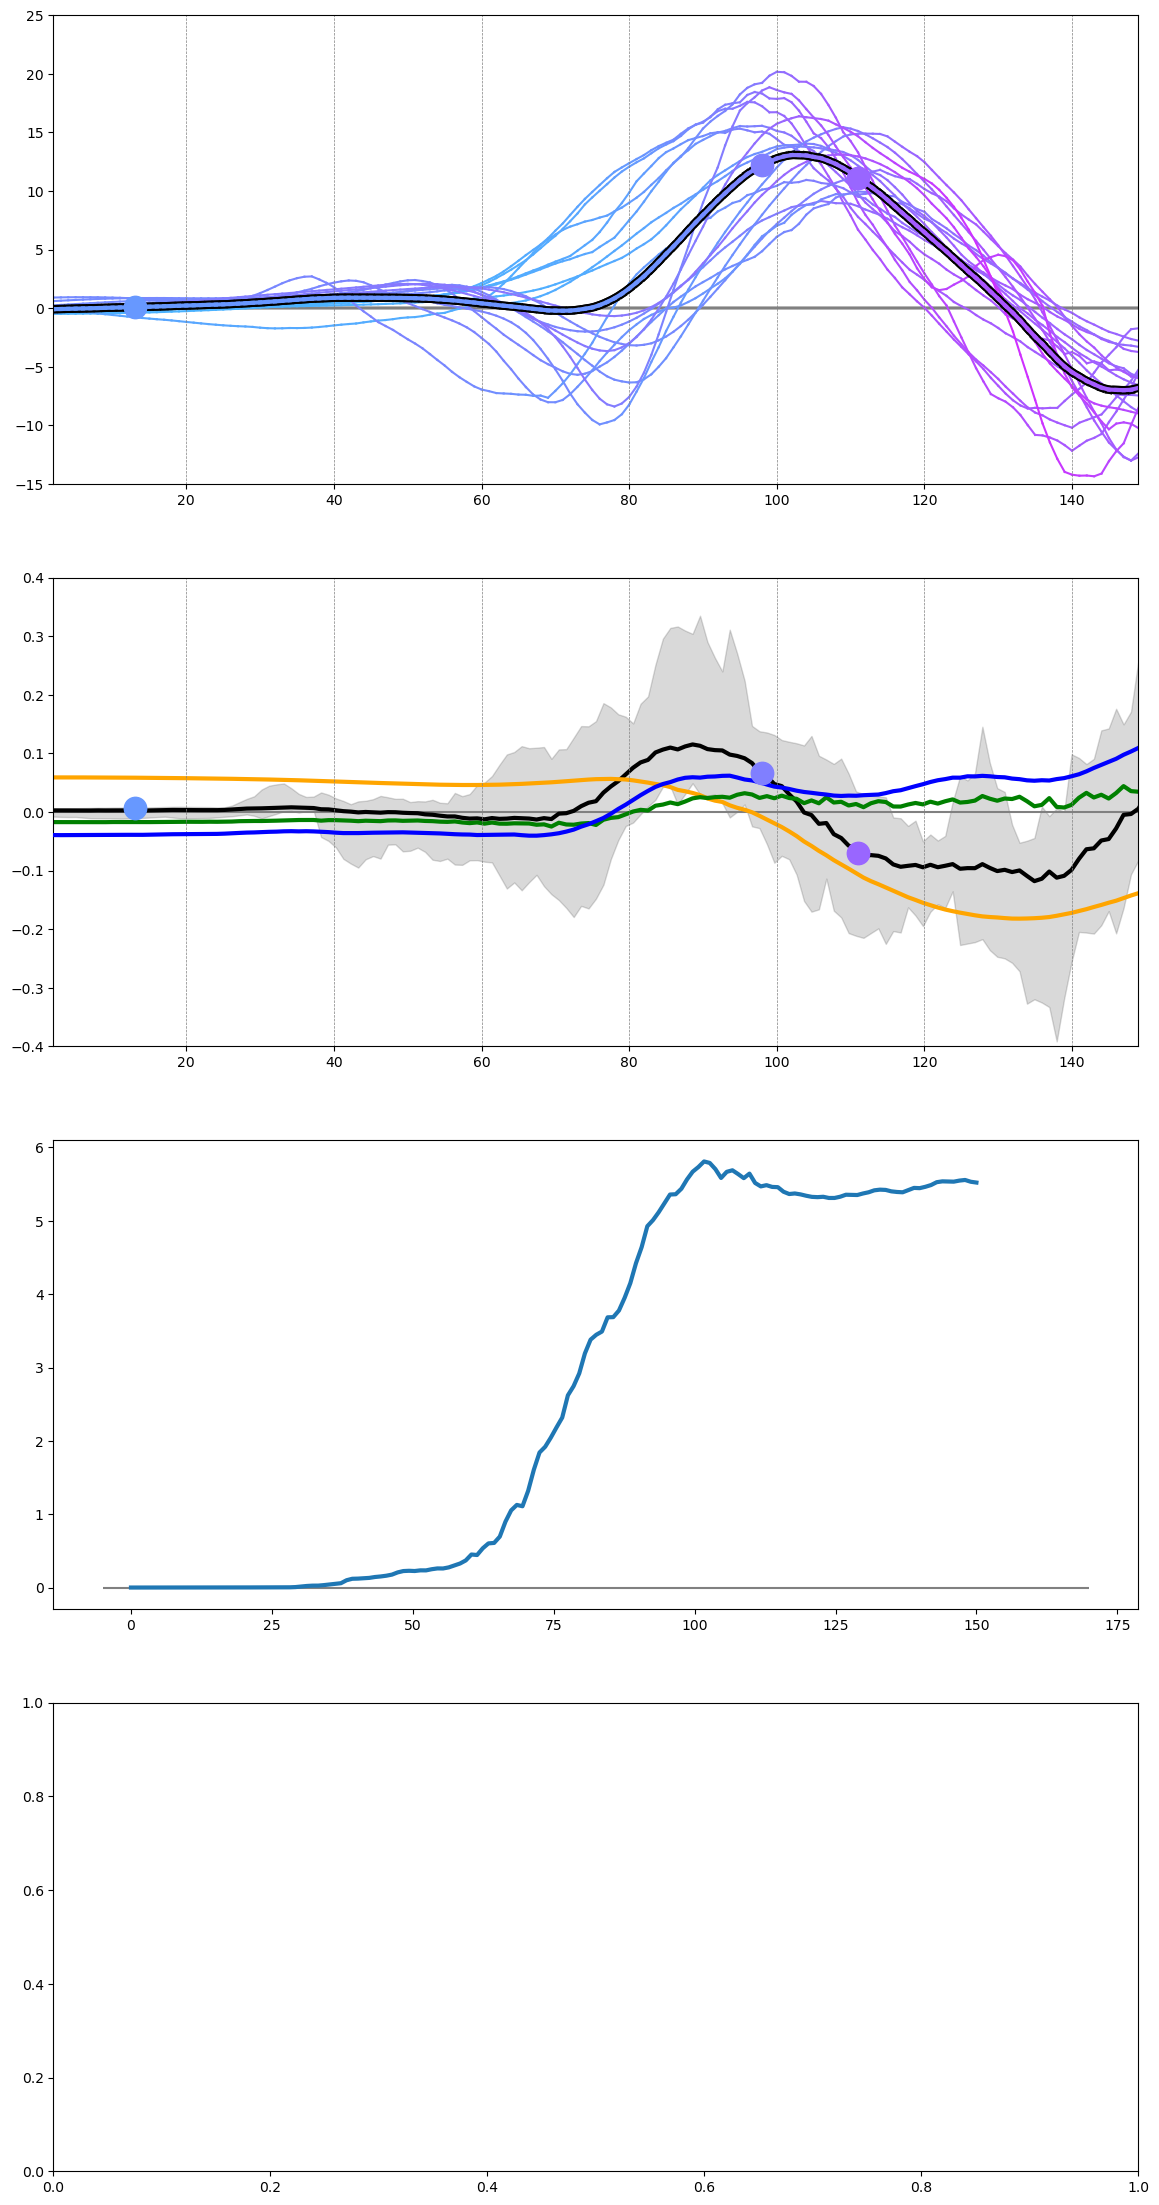

In [98]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1,figsize=(14,28)) # Set figure size and subplots
#fig, (ax1, ax2) = plt.subplots(2,1,figsize=(14,14)) # Set figure size and subplots
ax1.set_facecolor("white") # Background color
ax2.set_facecolor("white") # Background color

array_w = np.array(full_w_list_parcel)
array_dwdt = np.array(full_dwdt_list_parcel)
array_vpgf = np.array(full_vpgf_list_parcel)
array_pt1 = np.array(full_pt1_list_parcel)
array_buoy = np.array(full_buoy_list_parcel)
array_z = np.array(full_z_list_parcel)
array_time = np.array(prcl_times)

# Plot vertical velocity and height variables
mean_w = np.mean(array_w, axis = 0)
mean_z = np.mean(array_z, axis = 0)
z_cmap = plt.get_cmap("cool")
print("MEAN Z:", mean_z[0])
for hh in range(0,len(prcl_numbers)):
    #plt.plot(np.linspace(0,tmax,tmax), full_w_list[hh])
    #ax1.plot(np.linspace(tmin,tmax,tmax), full_w_list_parcel[hh])
    #ax1.plot(np.linspace(tmin,tmax,tmax), np.mean(array_w, axis = 0), linewidth = 3, color = "black")
    for tt in range(tmin,tmax-1):
        ax1.plot(np.linspace(tt,tt+1,2), array_w[hh][tt:tt+2], linewidth = 1.5, color = z_cmap(array_z[hh][tt:tt+1]/10000), zorder = 2)
    ax1.hlines(0,-5,170, color = "gray", zorder = 0)

mean_dwdt = np.mean(array_dwdt, axis = 0)
for tt in range(tmin,tmax-1):
    ax1.plot(np.linspace(tt,tt+1,2), mean_w[tt:tt+2], linewidth = 3, color = z_cmap(mean_z[tt:tt+1]/10000), zorder = 2.2)
    ax1.plot(np.linspace(tt,tt+1,2), mean_w[tt:tt+2], linewidth = 6, color = "black", zorder = 2.1)
    if tt > 3:
        if (round(mean_z[tt]/1000,1) == 1.0 or round(mean_z[tt]/1000,2) == 2.0 or round(mean_z[tt]/1000,2) == 3.0
            or (round(mean_z[tt]/1000,5) > 4.0491 and round(mean_z[tt]/1000,3) < 4.0496)
            or round(mean_z[tt]/1000,1) == 5.0 or round(mean_z[tt]/1000,1) == 6.0
            or (round(mean_z[tt]/1000,2) > 6.92 and round(mean_z[tt]/1000,2) < 7.08) or round(mean_z[tt]/1000,1) == 8.0 or (round(mean_z[tt]/1000,3) > 8.965 and round(mean_z[tt]/1000,2) < 9.025)
            or (round(mean_z[tt]/1000,2) > 9.98 and round(mean_z[tt]/1000,2) < 10.02)):
            ax1.scatter(tt, mean_w[tt], color = z_cmap(mean_z[tt]/10000), s = 260, zorder = 10)
            ax2.scatter(tt, mean_dwdt[tt]+0.005, color = z_cmap(mean_z[tt]/10000), s = 260, zorder = 10)
            #ax1.text(tt, mean_w[tt]-5, round(mean_z[tt]/1000,1), color = z_cmap(mean_z[tt]/10000))
            #ax1.text(tt, mean_w[tt]-5, tt, color = z_cmap(mean_z[tt]/10000))


#ax2.plot(np.linspace(tmin,tmax,tmax), np.mean(array_buoy, axis = 0), linewidth = 3, color = "blue")
#ax2.plot(np.linspace(tmin,tmax,tmax), np.min(array_buoy, axis = 0), linewidth = 1.5, color = "blue")
#ax2.plot(np.linspace(tmin,tmax,tmax), np.max(array_buoy, axis = 0), linewidth = 1.5, color = "blue")

# Color average parcel buoyancy line by EIL trac. conc.
trac_cmap = plt.get_cmap("pink_r")
mean_buoy = np.mean(array_buoy, axis = 0)
mean_pt1 = np.mean(array_pt1, axis = 0)
print("MEAN BUOY:", mean_buoy)
for qq in range(tmin,tmax-1):
    print(qq)
    #ax2.scatter([qq], mean_buoy, marker = "o", color = "red")#trac_cmap(mean_buoy[qq]/100))
    #ax2.plot(np.linspace(qq,qq+1,2), mean_buoy[qq:qq+2], linewidth = 3, color = trac_cmap(mean_pt1[qq:qq+1]/50 + 0.25), zorder = 2)

ax2.plot(np.linspace(tmin,tmax,tmax), np.mean(array_vpgf, axis = 0), linewidth = 3, color = "blue", zorder = 3)
#ax2.plot(np.linspace(tmin,tmax,tmax), np.min(array_vpgf, axis = 0), linewidth = 1.5, color = "orange")
#ax2.plot(np.linspace(tmin,tmax,tmax), np.max(array_vpgf, axis = 0), linewidth = 1.5, color = "orange")

#ax3.plot(np.linspace(tmin,tmax,tmax), full_pt1_list_parcel[mm], color = "green")
ax3.plot(np.linspace(tmin,tmax,tmax), np.mean(array_pt1, axis = 0), linewidth = 3)
#ax3.plot(np.linspace(tmin,tmax,tmax), np.max(array_pt1, axis = 0), linewidth = 1.5)

ax2.plot(np.linspace(tmin,tmax,tmax), np.mean(array_dwdt, axis = 0), linewidth = 3, color = "black", zorder = 0.5)
#ax2.plot(np.linspace(tmin,tmax,tmax), np.min(array_dwdt, axis = 0), linewidth = 1.5, color = "black")
#ax2.plot(np.linspace(tmin,tmax,tmax), np.max(array_dwdt, axis = 0), linewidth = 1.5, color = "black")

# Fill space between max_dwdt and min_dwdt (10/26/23)
ax2.fill_between(np.linspace(tmin,tmax,tmax), np.min(array_dwdt, axis = 0), np.max(array_dwdt, axis = 0), color = "black", alpha = 0.15, zorder = 0)

# parcel buoyancy
ax2.plot(np.linspace(tmin,tmax,tmax), np.mean(array_buoy, axis = 0), linewidth = 3, color = "orange", zorder = 0.5)


ax2.hlines(0,-5,170, color = "gray", zorder = 0)
ax3.hlines(0,-5,170, color = "gray", zorder = 0)

# Plot contribution to dw/dt from BPA/mixing/other
ax2.plot(np.linspace(tmin,tmax,tmax), np.mean(array_dwdt - array_buoy - array_vpgf, axis = 0), linewidth = 3, color = "green", zorder = 1)
#ax2.plot(np.linspace(tmin,tmax,tmax), np.min(array_dwdt - array_buoy - array_vpgf, axis = 0), linewidth = 1.5, color = "green")
#ax2.plot(np.linspace(tmin,tmax,tmax), np.max(array_dwdt - array_buoy - array_vpgf, axis = 0), linewidth = 1.5, color = "green")

ax1.set_ylim([-15,25]) # -15 to 40 for updraft parcels, -15 to 25 for midlevel parcels
ax1.set_xlim([2,149])

for uu in range(0,150,20):
    ax1.vlines(uu,-20,50,linestyles = "--", linewidths = 0.5, color = "gray")
    ax2.vlines(uu,-20,50,linestyles = "--", linewidths = 0.5, color = "gray")

#ax1.vlines(87,-20,50,linestyles = "--", linewidths = 0.5, color = "gray")
#ax2.vlines(87,-20,50,linestyles = "--", linewidths = 0.5, color = "gray")
#ax1.vlines(93,-20,50,linestyles = "--", linewidths = 0.5, color = "gray")
#ax2.vlines(93,-20,50,linestyles = "--", linewidths = 0.5, color = "gray")

ax2.set_ylim([-0.4,0.4])
ax2.set_xlim([2,149])

print(pdata['z'][-5:-1,500])
print(pdata['z'][0:5,500])



[]

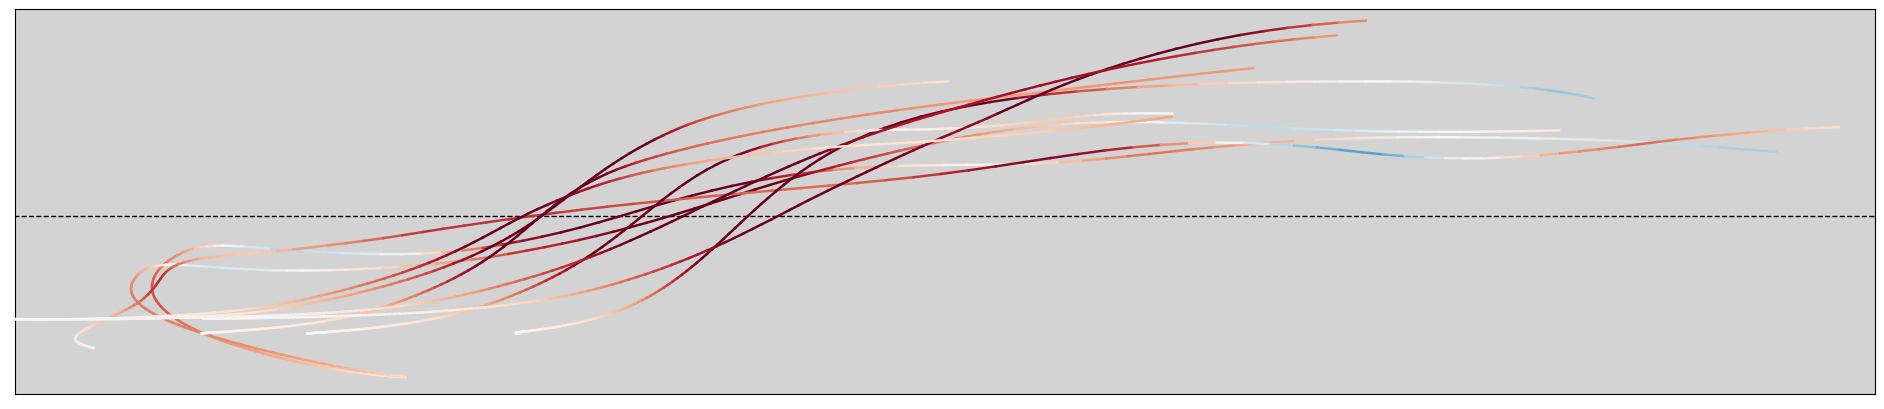

In [51]:
# 8/21/23 - analyze vertical cross sections

fig, (ax1) = plt.subplots(1,1,figsize=(24,5)) # Set figure size and subplots (change x in figsize to 24 for x-z parcel trajectory views)
ax1.set_facecolor("lightgray") # Background color

file = folder + "cm1out_000090.nc"
data = Dataset(file) # Prepare netCDF data to be read in from 3D data file

y_min = 280
y_max = 310
x = 200

w_cross = data['w'][0,0:150,:,x]
omegah_cross = ((data['xvort'][0,0:150,:,x]**2) + (data['yvort'][0,0:150,:,x]**2))**0.5
prs_pert_cross = data['prspert'][0,0:150,:,x]

#im1 = ax1.contour(w_cross, levels = [5, 10, 20, 30, 40, 50, 60], cmap = plt.get_cmap("YlOrRd"))
#im1 = ax1.contour(w_cross[:,y_min:y_max], levels = [5, 10, 20, 30, 40, 50, 60], colors = ["gray"])
o = plt.get_cmap("Oranges")
#im2 = ax1.contour(omegah_cross[:,y_min:y_max], levels = [0.02, 0.04, 0.06, 0.08, 0.1], colors = [o(0.2), o(0.4), o(0.6), o(0.8), o(0.9999)])
#im2 = ax1.contour(prs_pert_cross[:,y_min:y_max]/100, levels = [-10,-8,-6,-4,-2,-1,1,2,4,6,8,10], cmap = plt.get_cmap("seismic"))

# Plot parcel trajectories if desired
traj = True
if traj == True:
    for xx in range(0, len(prcl_numbers)):
        prcl_num = prcl_numbers[xx]
        for vv in range(tmin, tmax):
            ax1.plot(((pdata["x"][vv:vv+2,prcl_num]/250)) - y_min + y_center, (pdata["z"][vv:vv+2,prcl_num]/100), c = w_cmap((pdata["w"][vv,prcl_num]/50) + 0.5), zorder = 10, linewidth = 1.75) # Color lines based on parcel w
     

#plt.colorbar(im1, ax = ax1)

#ax1.invert_xaxis() # y-z plots
ax1.set_ylim([0,130]) # both plots (vertical gridpoints 0-130)
#ax1.set_xlim([30,-5]) # y-z plots (y-gridpoints 275-310)
ax1.set_xlim([-95,-25]) # x-z plots (x-gridpoints 185-255)
ax1.hlines(60,-100,100, linestyles = "--", linewidths = 1, color = "black")
ax1.set_xticks([]) # Turns off x-ticks
ax1.set_yticks([]) # Turns off y-ticks


In [30]:
# 8/27/23 - Calculate actual change in w due to DPA

# Updraft parcels:
'''
mean_w_sum = np.mean(array_dwdt, axis = 0)
print(mean_w_sum[76:96])
print(np.sum(mean_w_sum[76:96])*6)

mean_dpa_sum = np.mean(array_vpgf, axis = 0)
print(np.sum(mean_dpa_sum[76:96])*6)

mean_buoy_sum = np.mean(array_buoy, axis = 0)
print(np.sum(mean_buoy_sum[76:96])*6)
'''

# Mean "boost" from DPA from t = 77 timesteps to t = 97 timesteps: 11.308414936065674 m/s, 62% of total change in w of 18.384319829940797
# Buoyancy contributes 6.627725601196289 m/s (36%)

######### ######### #########

# Non updraft parcels:
mean_w_sum = np.mean(array_dwdt, axis = 0)
print(mean_w_sum[79:99])
print(np.sum(mean_w_sum[79:99])*6)

mean_dpa_sum = np.mean(array_vpgf, axis = 0)
print(np.sum(mean_dpa_sum[79:99])*6)

mean_buoy_sum = np.mean(array_buoy, axis = 0)
print(np.sum(mean_buoy_sum[76:96])*6)


# Mean "boost" from DPA from t = 80 timesteps to t = 100 timesteps: 5.9024351835250854 m/s, 52% of total change in w of 11.38268741001101
# Buoyancy contributes 4.412706613540649 (39%)

[0.0643535  0.07572151 0.08471648 0.08905268 0.10168376 0.10660236
 0.11007663 0.10688072 0.11203099 0.11540607 0.11311771 0.10747752
 0.10571828 0.10516663 0.09809572 0.09577617 0.09181141 0.08361527
 0.06855058 0.06126057]
11.38268741001101
5.9024351835250854
4.412706613540649
